In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from tqdm.auto import trange, tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

from data.dataloader import *

# sns.set(style='ticks', context='talk')
plt.style.use('seaborn-poster')
plt.style.use("paper.mplstyle")
np.random.seed(20201009)

# Data

In [2]:
def showcase_data(age_df, hr_df, **kwargs):
    display(hr_df.join(age_df["age"].groupby('snid').agg([list, len, np.mean, np.std]).add_prefix("age_")))

    # Joint plot of Age and HR row means
    sns.jointplot(x=age_df.groupby('snid').mean()['age'], y=hr_df['hr'], s=30).plot_joint(sns.kdeplot, zorder=0, n_levels=4)
    plt.xlabel("Age Posterior Sample Mean [Gyr]")
    plt.ylabel("Hubble Residual [mag]")
    plt.show()


## Campbell HR and Local Age

Hubble residual and local environment  age derived from the C13 dataset 

[C13]: Campbell, H., D’Andrea, C. B., Nichol, R. C., et al. 2013, ApJ, 763, 88

Missing from R19 Table 1 of SNID: {15459}
Missing from Campbell MCMC chains of SNID: {3256}
Resulting data will be an inner join of the two remove all SNID mentioned above


,hr,hr_err,age_list,age_len,age_mean,age_std
snid,,,,,,
762,0.15,0.08,"[5.105650637218932, 5.426390857309904, 8.23127...",50000.0,5.114123,2.392041
1032,-0.15,0.12,"[3.9733716483842656, 5.060704469395271, 2.5937...",50000.0,5.587337,2.364265
1371,-0.14,0.06,"[9.629968548258693, 9.007912196190736, 2.03108...",50000.0,7.193960,3.647477
1794,0.27,0.08,"[3.8316252692185375, 3.270402400923352, 2.5575...",50000.0,3.918969,1.371659
2372,-0.12,0.07,"[5.877710566551527, 6.8792269025281785, 5.6551...",50000.0,5.912454,1.674225
...,...,...,...,...,...,...
20764,-0.18,0.09,"[7.52283576695097, 9.145380579842763, 10.94632...",50000.0,8.746359,2.471066
21034,0.08,0.06,"[2.3711713875966995, 2.5675612947821245, 1.732...",50000.0,3.352937,1.093974
21487,-0.30,0.08,"[1.7054287233516017, 4.815469121716643, 2.7463...",50000.0,5.190174,0.998331


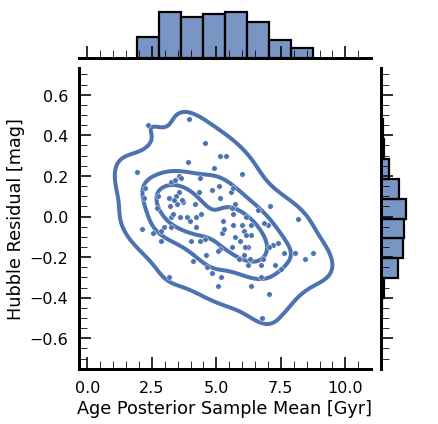

In [3]:
snids, age_df, hr_df = get_data("campbell")
showcase_data(age_df, hr_df)

## Campbell HR and Global Age

Hubble residual derived from the C13 dataset and global environment age dervied from SDSS-DR12.

* [C13]: Campbell, H., D’Andrea, C. B., Nichol, R. C., et al. 2013, ApJ, 763, 88
* [SDSS]: Sako, M., Bassett, B., Becker, A., et al. 2008, AJ, 135, 348

Missing from R19 Table 1 of SNID: {15459}
Missing from Campbell MCMC chains of SNID: {3256}
Resulting data will be an inner join of the two remove all SNID mentioned above


,hr,hr_err,age_list,age_len,age_mean,age_std
snid,,,,,,
762,0.15,0.08,"[5.105650637218932, 5.426390857309904, 8.23127...",50000.0,5.114123,2.392041
1032,-0.15,0.12,"[3.9733716483842656, 5.060704469395271, 2.5937...",50000.0,5.587337,2.364265
1371,-0.14,0.06,"[9.629968548258693, 9.007912196190736, 2.03108...",50000.0,7.193960,3.647477
1794,0.27,0.08,"[3.8316252692185375, 3.270402400923352, 2.5575...",50000.0,3.918969,1.371659
2372,-0.12,0.07,"[5.877710566551527, 6.8792269025281785, 5.6551...",50000.0,5.912454,1.674225
...,...,...,...,...,...,...
20764,-0.18,0.09,"[7.52283576695097, 9.145380579842763, 10.94632...",50000.0,8.746359,2.471066
21034,0.08,0.06,"[2.3711713875966995, 2.5675612947821245, 1.732...",50000.0,3.352937,1.093974
21487,-0.30,0.08,"[1.7054287233516017, 4.815469121716643, 2.7463...",50000.0,5.190174,0.998331


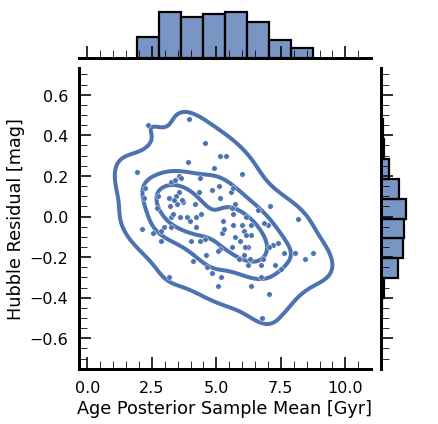

In [4]:
snids, global_age_df, hr_df = get_data("campbellG")
showcase_data(age_df, hr_df)

# Slope Analysis

In [5]:
from corner import corner

def plot_slope_analysis(name="local", burn=0):
    # DATA
    labels = ["intercept", "slope", "scatter"]
    results = {}
    for path in Path("results/pymc3/").glob(f"*_{name}.npz"):
        npz = np.load(path)
        results[path.stem.replace(f"_{name}", "")] = npz["arr_0"]
        
    print(results['slope'].std())
       
    # CORNER PLOT
    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(wspace=0, hspace=0)

    corner(np.vstack([results[label].flatten()[burn:] for label in labels]).T, 
           labels=labels, 
           show_titles=True,
           color='k',
           title_fmt='.3f', 
           title_kwargs={"fontsize": 16*1.1},
           lw=2,
           quantiles=stats.norm.cdf([-1, 0, 1]), fig=fig
    )
    plt.savefig(f"paper/figures/pymc3_corner_{name}.png", dpi=300)
    
    # TRACE PLOT
    fig, axes = plt.subplots(3, 1, figsize=(24, 4*3), sharex=True)
    fig.subplots_adjust(hspace=0)
    
    for i, label in enumerate(labels):
        ax = axes[i]
        for j in range(results[label].shape[0]):
            ax.plot(results[label][j, :], color='k', lw=0.5, alpha=0.5)

        ax.axvline(burn, c='#c44e52', label=f"Burn-in period ({burn})")
        
        ax.yaxis.get_major_ticks()[-1].label1.set_visible(False)
        ax.set_xlim(-1, results[label].shape[1])
        ax.set_ylabel(label)
        ax.set_xlabel("Iteration")
        if i == 0: ax.legend()
            
    # REGRESSION PLOT
    
    # SUMMARY STATISTICS
    summary = {}
    for i, label in enumerate(labels):
        summary[label] = (f"{results[label].flatten()[burn:].mean():.2g} \pm {results[label].flatten()[burn:].std():.2g}")
        
    display(pd.DataFrame([summary]))

0.007019873374246699


,intercept,slope,scatter
0,0.15 \pm 0.04,-0.035 \pm 0.007,1.6 \pm 1.2


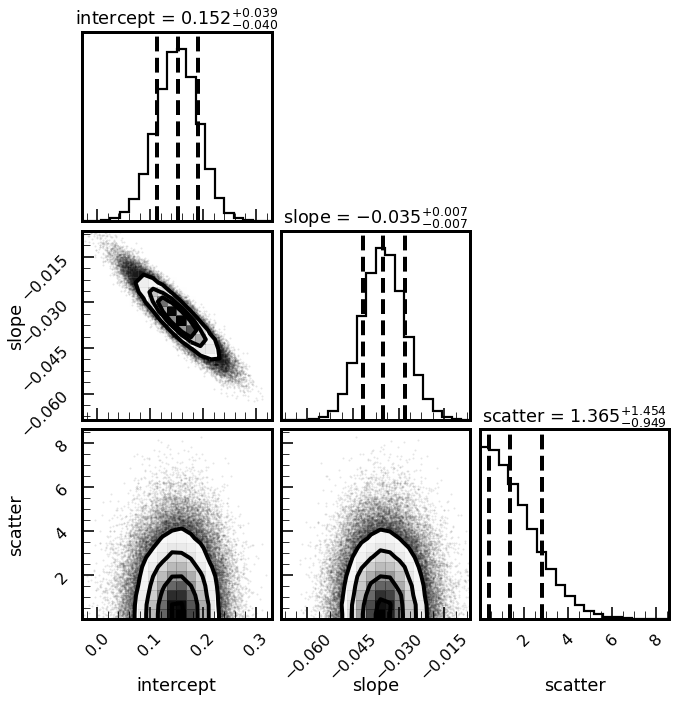

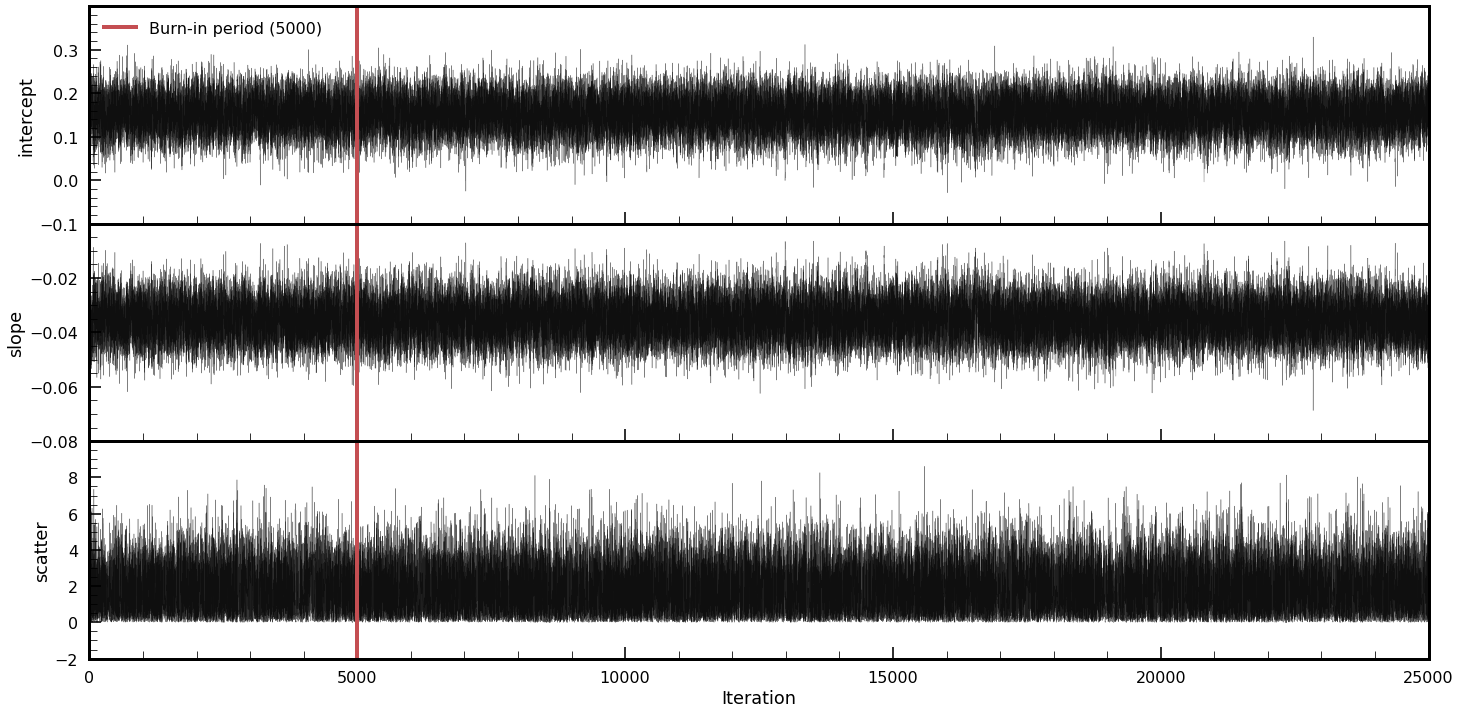

In [6]:
plot_slope_analysis(name="local", burn=5000)

0.00691202124984072


,intercept,slope,scatter
0,0.16 \pm 0.04,-0.036 \pm 0.0069,1.6 \pm 1.2


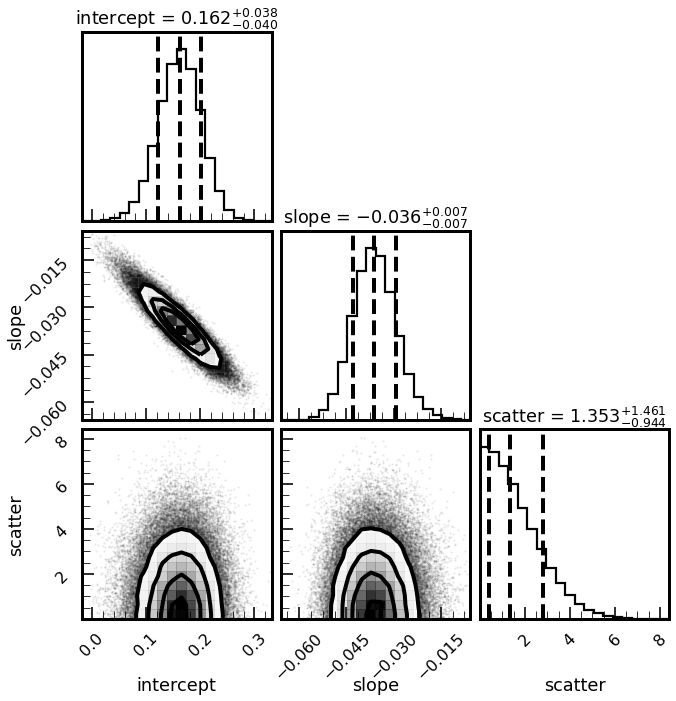

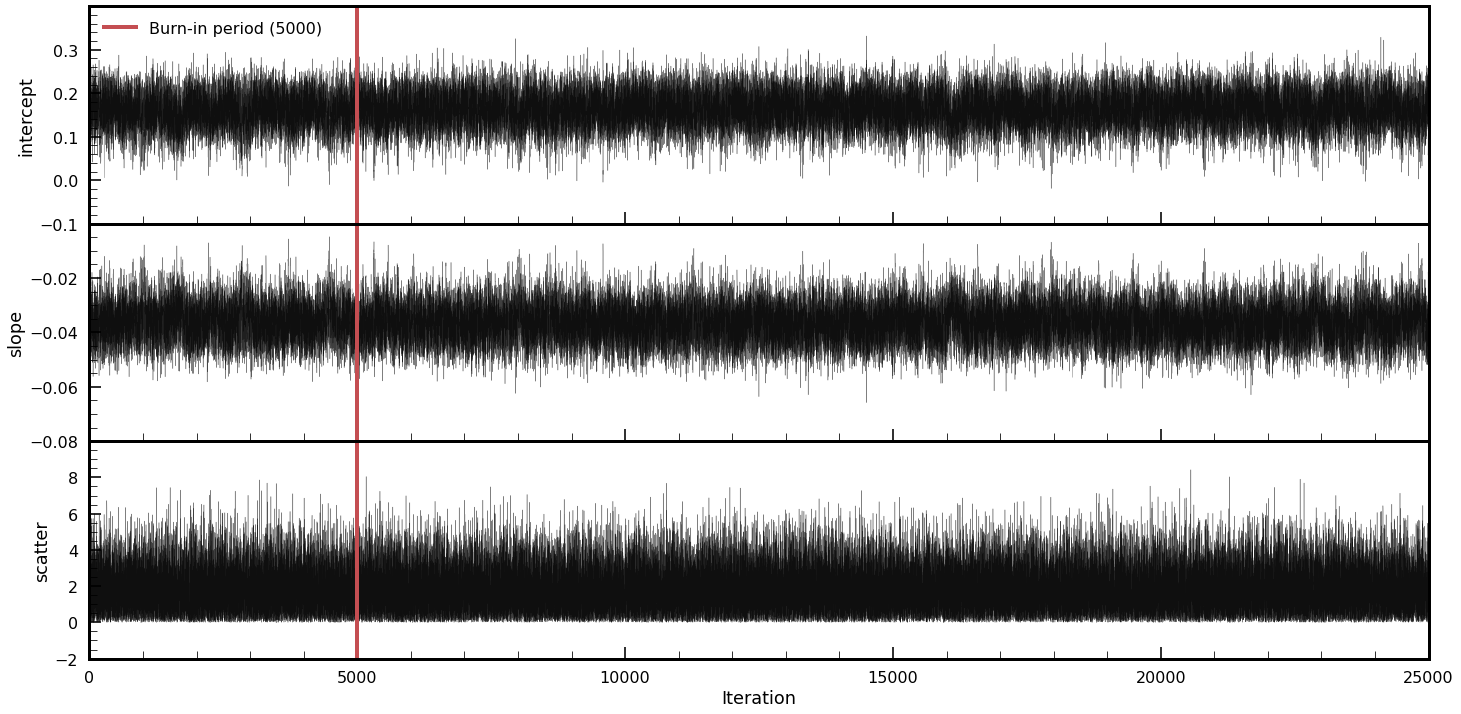

In [7]:
plot_slope_analysis(name="global", burn=5000)

# Correlation Analysis

* The biggest argument between Rose19 (or Rose20) and Lee20 is whether there is a correlation between HR and Age.
* Possible conclusions are:

    1. not enough data points
    2. there is no correlation
    3. there is a significant correlation, but it is not strong enough to deny dark energy
    4. there is a significant correlation, but slope is not large enough to deny dark energy
    5. there is a significant correlation, and slope is large enough to deny dark energy


notes:
* Lee20 claims number of samples causes 'dilution problem': how can we say this claim is not on point?
* Lee20 claims 'proper method' yields a large slope. If there are correlations, what is the slope?

In [8]:
from models.correlation import estimate_correlation

def plot_correlation_analysis(age_df, hr_df, name):
    # DATA
    results = []
    for i in trange(300):
        random_snids = np.random.choice(snids, size=len(snids), replace=True)
        result = estimate_correlation(age_df.groupby('snid').agg(['mean', 'var'])['age'].loc[random_snids, :], hr_df.loc[random_snids, :])
        results.append(result)

    results = np.array(results).reshape(100, 2)
    
    # PLOT
    sample_values = estimate_correlation(age_df.groupby('snid').agg(['mean', 'var'])['age'], hr_df)
    bins = np.linspace(-0.75, -0.15, 30)

    fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
    fig.subplots_adjust(wspace=0)

    ax = axs[0]
    ax.hist(results[:,0], bins, histtype="step", color='k', label=f"Bootstrap (${np.mean(results, axis=0)[0]:.2g}\pm{np.std(results, axis=0)[0]:.2g}$)")
    ax.axvline(sample_values[0], ls='--', label=f"Empirical (${sample_values[0]:.2g}$)")
    ax.set_title(f"Biased {name}")
    ax.legend()

    ax.set_ylabel("Count")
    ax.xaxis.get_major_ticks()[-1].label1.set_visible(False)


    ax = axs[1]
    ax.hist(results[:,1], bins, histtype="step", color='k',label=f"Bootstrap (${np.mean(results, axis=0)[1]:.2g}\pm{np.std(results, axis=0)[1]:.2g}$)")
    ax.axvline(sample_values[1], ls='--', label=f"Empirical (${sample_values[1]:.2g})$")
    ax.set_title(f"Corrected {name}")
    ax.legend()

    fig.add_subplot(111, frameon=False)
    plt.tick_params(which="both", labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel("Correlation")

    plt.savefig("paper/figures/correlation_estimation.pdf", bbox_inches='tight')
    
    
def plot_correlation_significance(age_df, hr_df, name):
    results = []
    for i in trange(300):
        random_age = age_df.groupby('snid').agg(['mean', 'var'])['age'].sample(frac=1, axis=0)
        random_hr_df = hr_df.sample(frac=1, axis=0)
        result = estimate_correlation(random_age, random_hr_df)
        results.append(result)

    results = np.array(results).reshape(300, 2)
    
    def get_discrepancy(sample_value, result_mean, result_std):
        return np.abs(sample_value - result_mean) / np.sqrt(0.047**2 + result_std**2)

    def get_pvalue(sample_value, bootstrap_sample):
        return np.mean(sample_values[1] > np.abs(results[:,1]))

    sample_values = estimate_correlation(age_df.groupby('snid').agg(['mean', 'var'])['age'], hr_df)
    bins = np.linspace(-0.4, 0.6, 30)
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
    fig.subplots_adjust(wspace=0)
    
    ax = axs[0]
    ax.hist(results[:,0], bins, histtype="step", color='k', label=f"Bootstrap null hypothesis\n(${np.mean(results, axis=0)[1]:.2g}\pm{np.std(results, axis=0)[1]:.2g}$)")
    ax.axvline(sample_values[0], ls='--', label=f"Empirical\n({sample_values[0]:.2g}, p={get_pvalue(sample_values[0], results[:,0])}, ${get_discrepancy(sample_values[0], np.mean(results, axis=0)[0], np.std(results, axis=0)[0]):.2g}\sigma$)")
    ax.set_title(f"Bias {name}")
    ax.legend()

    ax = axs[1]
    ax.hist(results[:,1], bins, histtype="step", color='k', label=f"Bootstrap null hypothesis\n(${np.mean(results, axis=0)[1]:.2g}\pm{np.std(results, axis=0)[1]:.2g}$)")
    ax.axvline(sample_values[1], ls='--', label=f"Empirical\n({sample_values[1]:.2g}, p={get_pvalue(sample_values[1], results[:,1])}, ${get_discrepancy(sample_values[1], np.mean(results, axis=0)[1], np.std(results, axis=0)[1]):.2g}\sigma$)")
    ax.set_title(f"Corrected {name}")
    ax.legend()

In [9]:
plot_correlation_analysis(age_df, hr_df, name="Pearson correlation")
plot_correlation_significance(age_df, hr_df, name="Pearson correlation")

ValueError: cannot reshape array of size 600 into shape (100,2)

In [ ]:
# plot_correlation_analysis(age_df.groupby("snid").rank(), hr_df.rank(), name="Spearman correlation")
# plot_correlation_significance(age_df.groupby("snid").rank(), hr_df.rank(), name="Spearman correlation")

In [ ]:
plot_correlation_analysis(global_age_df, hr_df, name="Pearson correlation")
plot_correlation_significance(global_age_df, hr_df, name="Pearson correlation")

In [ ]:
# plot_correlation_analysis(global_age_df.groupby("snid").rank(), hr_df.rank(), name="Spearman correlation")
# plot_correlation_significance(global_age_df.groupby("snid").rank(), hr_df.rank(), name="Spearman correlation")

## Demonstrating the Naive Method &mdash; Bootstrap Sampling Age and Hubble Residual
To determine correlation, statistical simulation by sampling the age and HR simulation joint distribution provides a estimate of the true correlation without the need for model-fitting. For each SNe, the variablility of age and HR is accounted for with large enough samples of each distribution.

For each of the $N_\text{snid}$ SNe,

* 10000 samples without replacement of HR assuming Gaussian distribution given its respective parameters.
* 10000 samples without replacement of Age given the MCMC-derived posterior sample with no fitting of its distribution.

The total sample size is $N_\text{snid} \times 10000$

In [ ]:
def simulate(age_df, hr_df, sample_size=10000):
    sample_dfs = []
    for i, snid in enumerate(snids):
        print(f"{i}/{len(snids)}", end="\r")
        # Age ~ MCMC marginalized posterior of given SNID
        snid_age_sample = RNG.choice(age_df.loc[snid, "age"], size=sample_size)

        # HR ~ Normal(hr[snid], hr_err[snid])
        snid_hr_dist = stats.norm(loc=hr_df.loc[snid, "hr"], scale=hr_df.loc[snid, "hr_err"])
        snid_hr_dist.random_state = RNG
        snid_hr_sample = snid_hr_dist.rvs(size=sample_size)

        sample_df = pd.DataFrame({
            "age": snid_age_sample,
            "hr": snid_hr_sample
        }, index=[snid]*sample_size)
        sample_dfs.append(sample_df)

    print(f"{i+1}/{len(snids)}", end="\r")
    result_df = pd.concat(sample_dfs)
    result_df.index.name = "snid"
    result_df.to_csv(RESULTSPATH/"campbell_hr_age_simulation.csv")

def get_simulation():
    return pd.read_csv(RESULTSPATH/"campbell_hr_age_simulation.csv")

# simulate(age_df, hr_df)
result_df = get_simulation()

# Summary

In [ ]:
# summary_df = pd.DataFrame({
#                             "bootstrap":  {
#                                 "slope": result_df["slope"].mean(),
#                                 "slope_sd": result_df["slope"].std(),
#                                 "intercept": result_df["intercept"].mean(),
#                             },
#                             "bootstrap_g": {
#                                 "slope": result_gaussian_df["slope"].mean(),
#                                 "slope_sd": result_gaussian_df["slope"].std(),
#                                 "intercept": result_gaussian_df["intercept"].mean(),
#                             },
#                             "Rose19": {
#                                 "slope": -0.1/7,
#                                 "slope_sd": 0,
#                                 "intercept": 0.05
#                             },
#                             "Lee20": {
#                                 "slope": -0.057,
#                                 "slope_sd": 0.016,
#                                 "intercept": 0.22
#                             },
#                          })

# fig = plt.figure(figsize=(24, 8))
# ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=3)
# ax2 = plt.subplot2grid((3, 3), (0, 1), rowspan=2, colspan=2)
# ax3 = plt.subplot2grid((3, 3), (2, 1), colspan=2)

# ax1.errorbar(age_df["age"].groupby('snid').mean(), hr_df["hr"], xerr=age_df["age"].groupby('snid').std(), yerr=hr_df['hr_err'], fmt='ko', lw=0.5, ms=5)
# xrange = np.linspace(0, 12, 100)

# slope, intercept = summary_df.loc[["slope", "intercept"], "bootstrap"]
# ax1.plot(xrange, slope*xrange + intercept, 'k', lw=3, label=f"Bootstrap")

# slope, intercept = summary_df.loc[["slope", "intercept"], "bootstrap_g"]
# ax1.plot(xrange, slope*xrange + intercept, 'k--', lw=3, label=f"Bootstrap (Gaussian)")

# slope, intercept = summary_df.loc[["slope", "intercept"], "Rose19"]
# ax1.plot(xrange, slope*xrange + intercept, lw=3, label=f"Rose et al. 2019")

# slope, intercept = summary_df.loc[["slope", "intercept"], "Lee20"]
# ax1.plot(xrange, slope*xrange + intercept, 'r', lw=3, label=f"Lee et al. 2020")

# ax1.legend()
# ax1.set_xlabel("Local age [Gyr]")
# ax1.set_ylabel("Hubble residual [mag]")

# xrange = np.linspace(-0.1, 0, 1000)
# # ax2.hist([result_df['slope'], result_gaussian_df['slope']], density=True, bins=15, color=["k", "gray"], label=["Bootstrap", "Bootstrap (Gaussian)"])
# ax2.plot(xrange, stats.norm(loc=summary_df.loc["slope", "bootstrap_g"], scale=summary_df.loc["slope_sd", "bootstrap_g"]).pdf(xrange), "k--", label="Bootstrap (Gaussian)")
# ax2.plot(xrange, stats.norm(loc=summary_df.loc["slope", "bootstrap"], scale=summary_df.loc["slope_sd", "bootstrap"]).pdf(xrange), "k", label="Bootstrap")
# ax2.plot(xrange, stats.norm(loc=summary_df.loc["slope", "Lee20"], scale=summary_df.loc["slope_sd", "Lee20"]).pdf(xrange), c="r", label="Lee et al. 2020")
# ax2.axvline(summary_df.loc["slope", "Rose19"], ymax=0.95, label="Rose et al. 2019")

# ax2.legend()
# ax2.set_xlabel("Slope")
# ax2.set_ylabel("Number Density")
# ax2.set_xlim(-0.1, 0)

# plt_table= pd.plotting.table(ax3, summary_df.T.round(3), loc='center')
# plt_table.auto_set_font_size(False)
# plt_table.set_fontsize(16)
# plt_table.scale(1., 1.8)

# ax3.axis("off")
# plt.tight_layout()

In [ ]:
def get_slope_parameter(x, y):
    """Return the mean and variance of the OLS slope parameter"""
    corr = stats.pearsonr(x, y)[0]
    slope = corr * (np.std(y) / np.std(x))
    
    sigma2 = (np.var(y)**2 + np.var(x)**2)
    slope_var = sigma2 / np.sum((x-np.mean(x))**2)
    
    return slope, slope_var

fig, axes = plt.subplots(ncols=2, figsize=(16, 8), sharey=True, squeeze=True)
ax1, ax2 = axes

summary = {}

# Plot Data
ax1.errorbar(age_df["age"].groupby('snid').mean(), hr_df["hr"], xerr=age_df["age"].groupby('snid').std(), yerr=hr_df['hr_err'], fmt='ko', lw=0.5, ms=5, zorder=0)

## Bootstrap Sample
x, y = result_df['age'], result_df['hr']
ax2.hist2d(x, y, bins=100, cmap='gray_r', zorder=0)

# Plot Regressions
xrange = np.linspace(0, 12, 100)

## OLS Bootstrap Regression
corr, pvalue_corr = stats.pearsonr(x, y)
rcorr, pvalue_rcorr = stats.spearmanr(x, y)
slope, slope_var = get_slope_parameter(x, y)
intercept = np.mean(y) - slope*np.mean(x)
[ax.plot(xrange, slope*xrange + intercept, linestyle='dashdot', label=f"Ordinary Least Squares (OLS)") for ax in axes]
summary["OLS"] = {"slope": slope, "intercept": intercept}

## ODR MCMC Regression
slope = -0.055
intercept =  0.25
[ax.plot(xrange, slope*xrange + intercept, linestyle='dashdot', label=f"Orthogonal Regression (ODR)") for ax in axes]
summary["ODR"] = {"slope": slope, "intercept": intercept}

# Rose19 Regression
slope = -0.1/7
intercept = 0.05
[ax.plot(xrange, slope*xrange + intercept, linestyle='dashdot', label=f"Bootstrap, Rose et al. 2019 (approx.)") for ax in axes]
summary["Boostrap, Rose et al. (2019)"] = {"slope": slope, "intercept": intercept}


## LINMIX Lee20 
slope = -0.057
intercept =  0.22
[ax.plot(xrange, slope*xrange + intercept, linestyle='dashdot', label=f"LINMIX, Lee et al. 2020") for ax in axes]
summary["LINMIX, Lee et al. (2020)"] = {"slope": slope, "intercept": intercept}

## Ours
results = {}
for path in Path("results/pymc3/").glob(f"*_local.npz"):
    npz = np.load(path)
    results[path.stem.replace(f"_local", "")] = npz["arr_0"]
slope = results['slope'].mean()
intercept =  results['intercept'].mean()
[ax.plot(xrange, slope*xrange + intercept, color='k', label=f"Our proposed model") for ax in axes]
summary["Proposed Model"] = {"slope": slope, "intercept": intercept}

for ax in axes:
    ax.set_xlabel("Local age [Gyr]")
    ax.set_xlim(0, 12)
    ax.set_xticks(np.arange(0, 14, 2))
    
    ax.set_yticks(np.arange(-0.8, 1, 0.2))

ax1.xaxis.get_major_ticks() [-1].label1.set_visible(False)
ax1.set_ylabel("Hubble residual [mag]")

handles, labels = ax2.get_legend_handles_labels()
order = [4, 0, 1, 2, 3]
labels, handles = np.array(labels)[order].tolist(), np.array(handles)[order].tolist()
ax2.legend(handles, labels, loc='upper right', handlelength=3)
    
plt.tight_layout()
fig.subplots_adjust(wspace=0)
plt.savefig(FIGURESPATH/"summary_line_fit.pdf", facecolor='white', dpi=300)

summary_df = pd.DataFrame(summary).round(3).T
display(summary_df)
print(summary_df.to_latex())

# Supplementary

## Downsample Analysis

In [ ]:
results = []
for snid in tqdm(snids):
    all_global_age_df = pd.read_table(DATAPATH/f"mcmc_chains/campbellG/SN{snid}_campbellG_chain.tsv", skiprows=[1], index_col=False, usecols=[7], sep="\t")
    ks, pvalue = stats.ks_2samp(global_age_df.loc[snid, 'age'], all_global_age_df['age'])
    result = {
        "snid": snid,
        "ks": ks,
        "pvalue": pvalue 
    }
    results.append(result)
    
ks_df = pd.DataFrame(results).set_index('snid').sort_values('pvalue', ascending=True)
ks_df

In [ ]:
for snid in [ks_df.index[-1], ks_df.index[0]]:
    all_global_age_df = pd.read_table(DATAPATH/f"mcmc_chains/campbellG/SN{snid}_campbellG_chain.tsv", skiprows=[1], index_col=False, usecols=[7], sep="\t")

    fig, ax1 = plt.subplots()
    
    color = "#4c72b0"
    ax1.hist(all_global_age_df['age'], bins=50, color=color, histtype='step', cumulative=True, label='all')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend("upper left")
    
    color = "#dd8452"
    ax2 = ax1.twinx()
    ax2.hist(global_age_df.loc[snid, 'age'], bins=50, color=color, linestyle="--", histtype='step', cumulative=True, label='downsample')
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.legend("upper right")

    
    ax1.set_title(f"{snid} {ks_df.loc[snid, :].round(3).to_dict()}")

In [ ]:
plt.figure(figsize=(32, 6))
plt.bar(ks_df.index.astype(str), ks_df.pvalue)
plt.axhline(0.05, color='#dd8452', label="5% Line")

plt.xticks(rotation=90)
plt.minorticks_off()
plt.xlim(-1, len(ks_df))
plt.ylim(0, 1)

plt.xlabel("SNID")
plt.ylabel("Kolmogorov-Smirnoff Test p-value")
plt.legend();

In [ ]:
# def simulate(age_df, hr_df, reps=1000):
#     assert len(age_df.index.unique()) == len(hr_df)
#     sample_size = len(hr_df)
    
#     corrs = []
#     rcorrs = []
#     slopes = []
#     intercepts = []
#     for i in range(reps):
#         xsample = age_df.groupby('snid').sample(1)['age']
        
#         ydist = stats.norm(loc=hr_df['hr'], scale=hr_df['hr_err'])
#         ysample = ydist.rvs(sample_size)
        
#         corr = stats.pearsonr(xsample, ysample)[0]
#         corrs.append(corr)
        
#         rcorr = stats.spearmanr(xsample, ysample)[0]
#         rcorrs.append(rcorr)

#         slope = corr * (np.std(ysample) / np.std(xsample))
#         slopes.append(slope)
        
#         intercept = np.mean(ysample) - slope*np.mean(xsample)
#         intercepts.append(intercept)
        
#         if (i+1) % 100 == 0: 
#             print(f"{i+1}/{reps}", end="\r")
    
    
#     result_df = pd.DataFrame({"corr": corrs, "rcorr": rcorrs, "slope": slopes, "intercept": intercept})
#     result_df.to_csv(RESULTSPATH/"campbell_hr_age_simulation.csv", index=False)

# def get_simulation():
#     return pd.read_csv(RESULTSPATH/"campbell_hr_age_simulation.csv")

# # simulate(age_df, hr_df)
# result_df = get_simulation()

## Gaussian Mixture Model

In [57]:
age_df.groupby('snid').agg(pd.DataFrame.kurtosis).sort_values('age')

,age
snid,
20064,-1.548035
6558,-1.424837
18835,-1.339001
19772,-1.284106
14279,-1.246268
...,...
21487,2.254989
20764,2.599035
18650,3.644157


In [170]:
import pickle
from models.gaussian_mixture import GaussianMixture

def plot_gmm(age_df, gmm):
    # DATA
    gmm_params = pd.read_csv(gmm.params_fpath, index_col="snid")
    age_df_kurt_sort = age_df.groupby('snid').agg(pd.DataFrame.kurtosis).sort_values('age')
    snids = age_df_kurt_sort.index[:20]
    
    nrows, ncols = 5, 4
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*8, nrows*4), sharex=True, sharey=True)

    bins = np.arange(0, 16, 0.5)
    for i, snid in enumerate(snids):
        ax = axs[i//ncols, i%ncols]
        ax.hist(age_df.loc[snid], bins, histtype="step", color='k', density=True)
        
        xrange = np.linspace(0, 15, 1000)
        params = gmm_params.loc[snid]
        probs = (
            params['weight0']*stats.norm(params['mean0'], params['sigma0']).pdf(xrange) +
            params['weight1']*stats.norm(params['mean1'], params['sigma1']).pdf(xrange) +
            params['weight2']*stats.norm(params['mean2'], params['sigma2']).pdf(xrange)
        )
        ax.plot(xrange, probs) 
        
        
        ax.set_xlim(0, 16)
        yticks = np.arange(0, 1.1, 0.1)
        ax.set_yticks(yticks)
        ax.set_yticklabels([str(int(tick * 50000 / 1000)) for tick in yticks])

        
        ax.text(.18, .9, f"SNID {snid}", horizontalalignment='center', transform=ax.transAxes, fontsize=20)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=len(ax.get_yticks()), prune='upper'))
        ax.xaxis.set_major_locator(MaxNLocator(nbins=len(ax.get_xticks()), prune='upper'))
        
        ax.tick_params(axis='both', which='major', labelsize=19.2)


        
        
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(which="both", labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.ylabel("Count (thousand)", fontsize=24)
    plt.xlabel("Age (Gyr)", fontsize=24)
        
    plt.tight_layout()
    fig.subplots_adjust(hspace=0, wspace=0)
    plt.savefig(f"paper/figures/age_posterior_samples_{gmm.name}.pdf")


def plot_gmm_slide(age_df, gmm):
    # DATA
    gmm_params = pd.read_csv(gmm.params_fpath, index_col="snid")
    
    # PLOT
    nrows, ncols = 4, 1
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*8, nrows*4), sharex=True)
    axs = axs.reshape(nrows, ncols)

    xrange = np.linspace(0, 15, 1000)
    bins = np.linspace(xrange.min(), xrange.max(), 100)
    random_snids = np.random.choice(snids, size=nrows*ncols)
    # random_snids = [1794, 21502, 6936, 3674]
    for i in range(nrows*ncols):
        if i >= len(random_snids):
            break
        else:    
            snid = random_snids[i]

        ax = axs[i//ncols, i%ncols]
        hr_row = hr_df.loc[snid, :]

        ax.hist(age_df.loc[snid, :], bins, density=True, color='k', histtype="step")

        params = gmm_params.loc[snid]
        probs = (
            params['weight0']*stats.norm(params['mean0'], params['sigma0']).pdf(xrange) +
            params['weight1']*stats.norm(params['mean1'], params['sigma1']).pdf(xrange) +
            params['weight2']*stats.norm(params['mean2'], params['sigma2']).pdf(xrange)
        )
        ax.plot(xrange, probs)

        ax.set_title(f"SNID {snid} \n", loc="left", x=-1, y=0.5, va="center")
        ax.set_ylabel(f"${hr_row['hr']:.2f}\pm{hr_row['hr_err']:.2f}$\n[mag]", rotation='horizontal', labelpad=80)
        ax.yaxis.set_tick_params(which='both', left=False, labelleft=False)
    
    plt.xlim(0, 15)
    fig.subplots_adjust(hspace=0)
    plt.xlabel("Age [Gyr]")
    plt.savefig(f"paper/figures/gmm_age_posterior_fit_{gmm.name}.png", transparent=False)


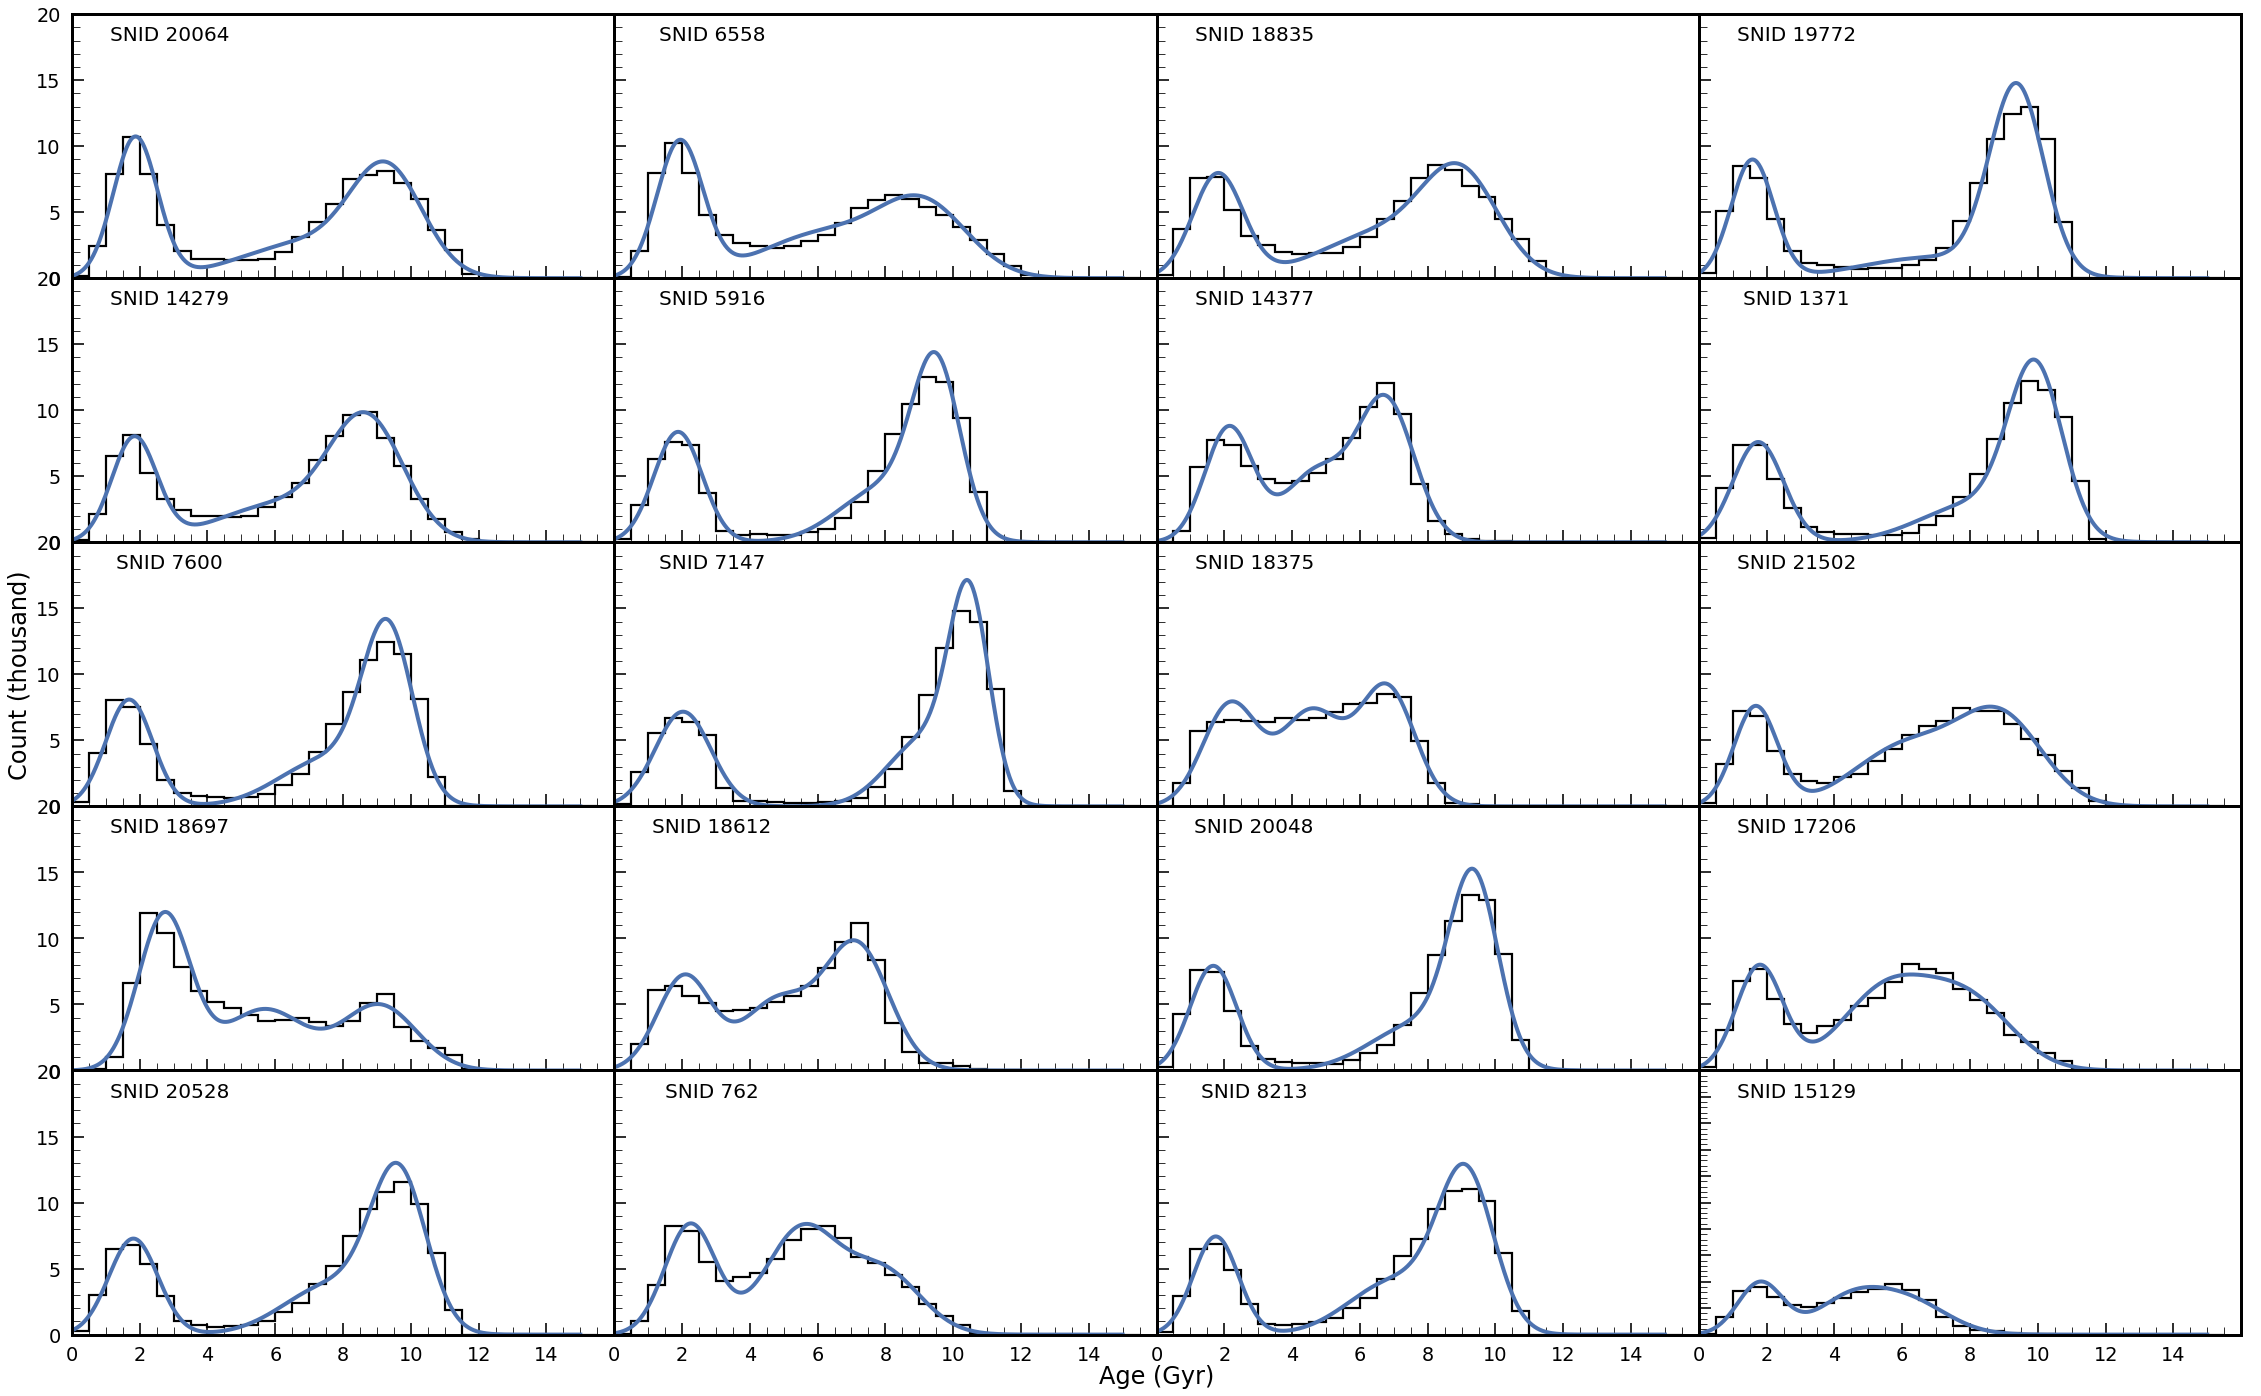

In [171]:
gmm = GaussianMixture("local")
plot_gmm(age_df, gmm)

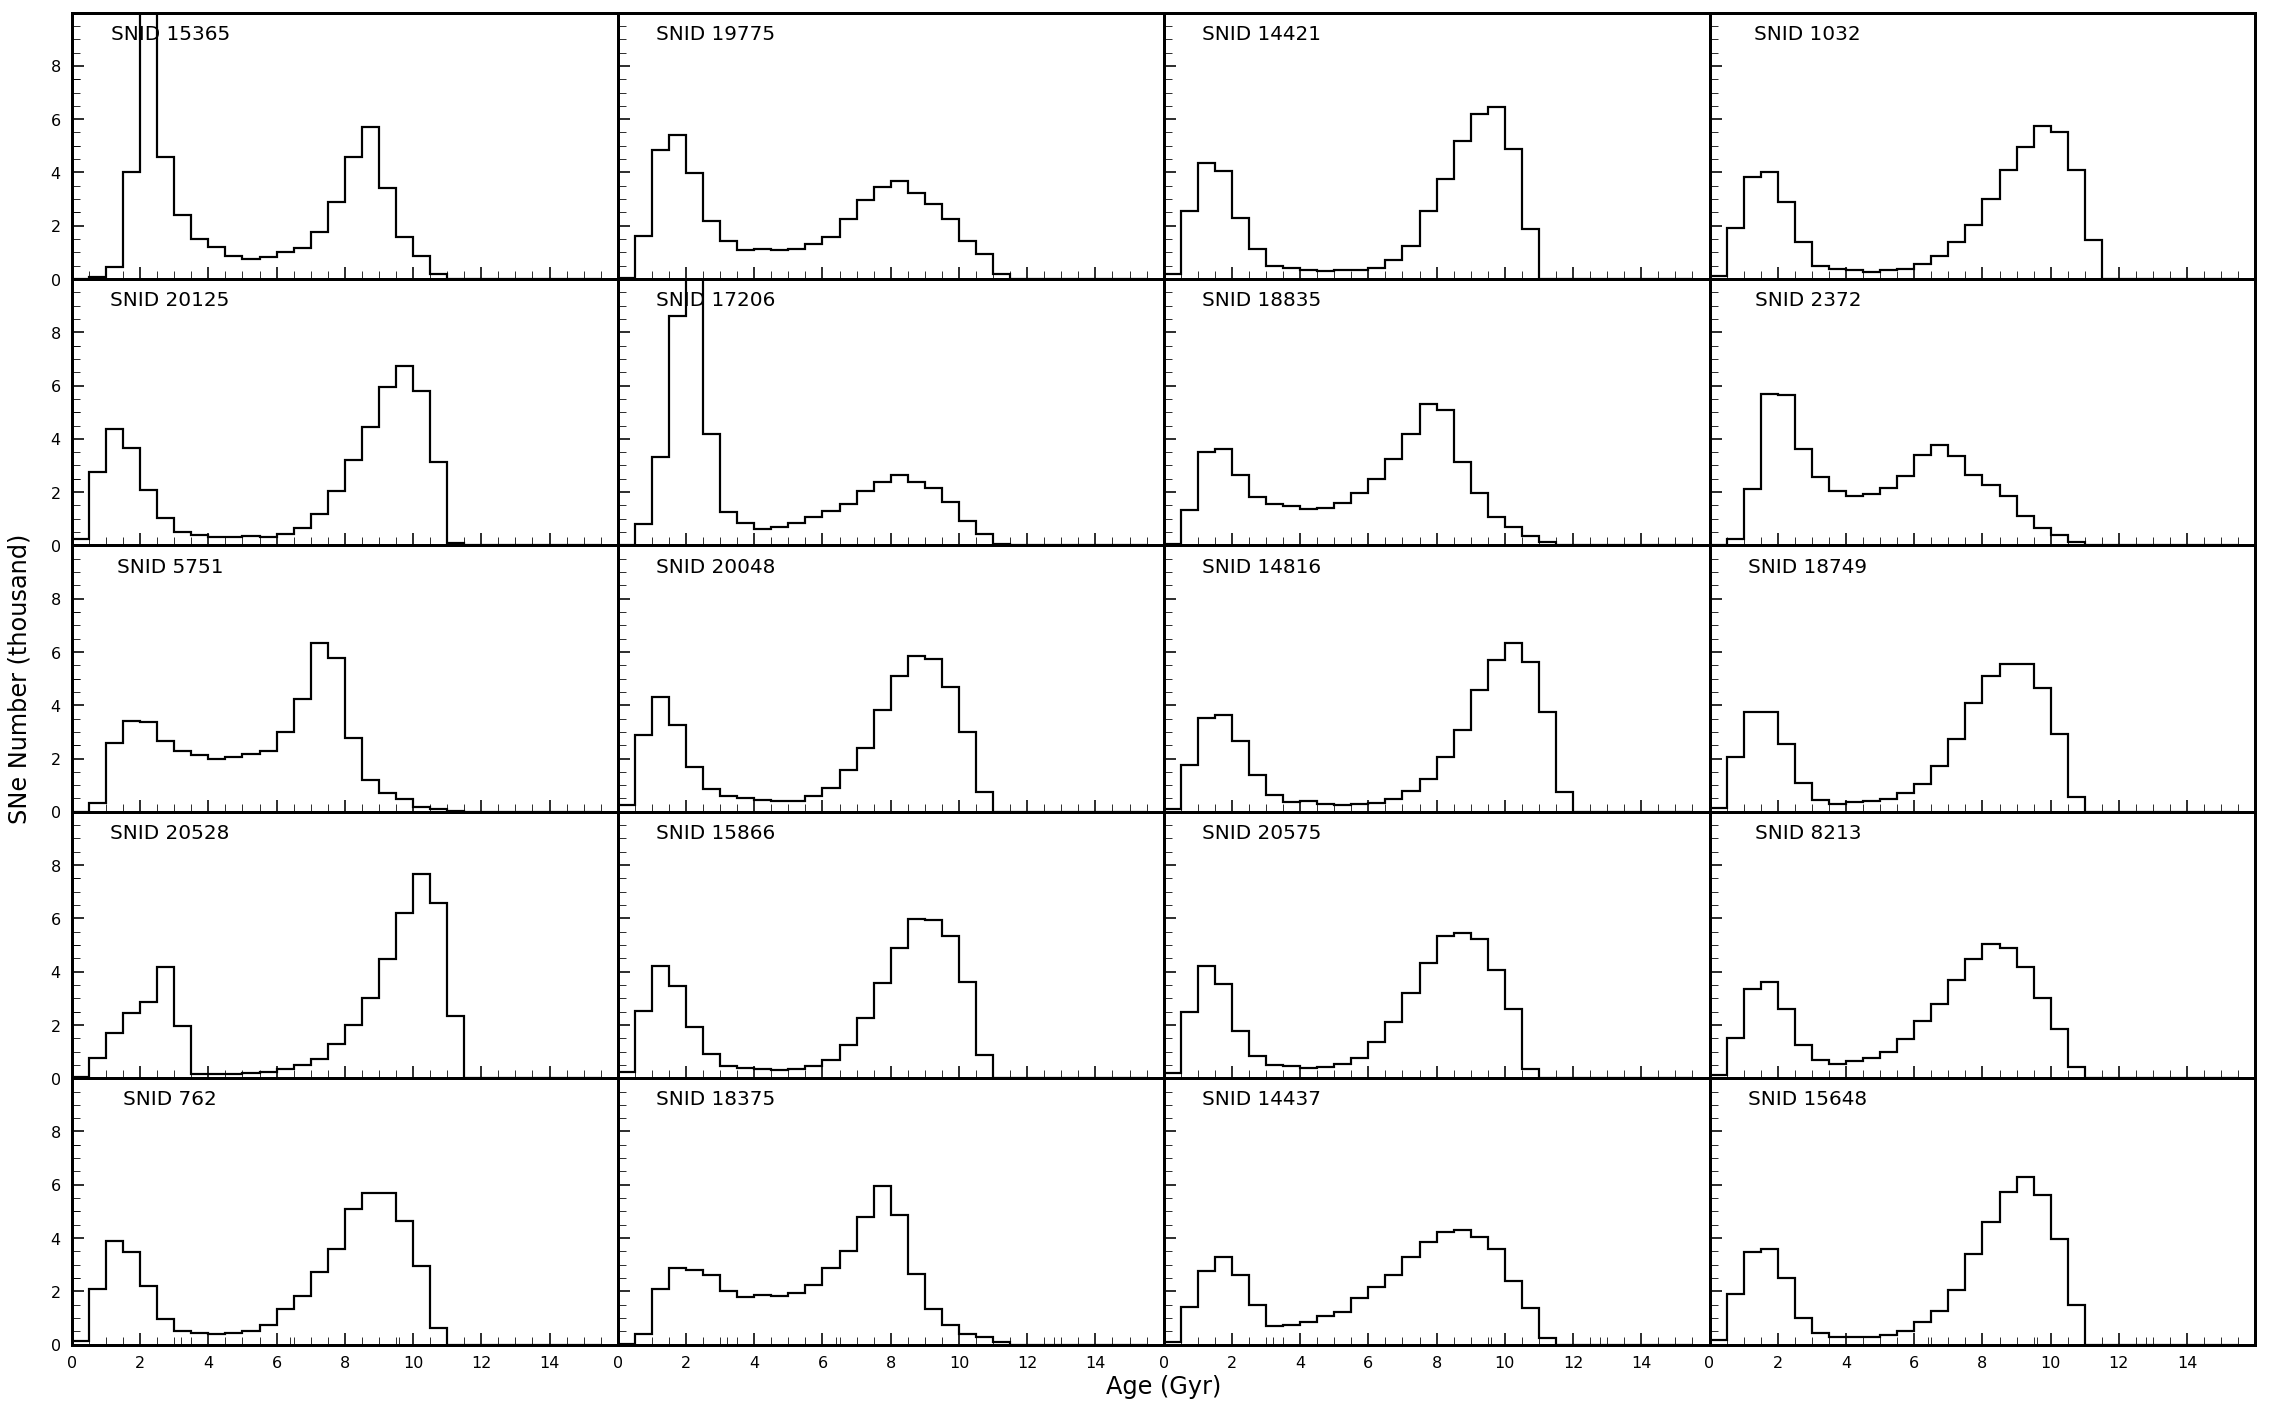

In [99]:
gmm = GaussianMixture("global")
plot_gmm(global_age_df, gmm)

## Correlation Analysis with All Gaussian Errors

Attempting to incorrectly do correlation analysis that L20 did which changes the previous correlation analysis by the assumption of the Age distribution:

* 10000 samples without replacement of Age assumed to be <span style="color: red">Gaussian parameters from the MCMC-derived posterior mean and SD</span>.

In [ ]:
def simulate_with_gaussian(age_df, hr_df, reps=1000):
    assert len(age_df.index.unique()) == len(hr_df)
    sample_size = len(hr_df)
    
    corrs = []
    rcorrs = []
    slopes = []
    intercepts = []
    for i in range(reps):
        xdist = stats.norm(loc=age_df['age'].groupby('snid').mean(), scale=age_df['age'].groupby('snid').std())
        xsample = xdist.rvs(sample_size)
        
        ydist = stats.norm(loc=hr_df['hr'], scale=hr_df['hr_err'])
        ysample = ydist.rvs(sample_size)
        
        corr = stats.pearsonr(xsample, ysample)[0]
        corrs.append(corr)
        
        rcorr = stats.spearmanr(xsample, ysample)[0]
        rcorrs.append(rcorr)

        slope = corr * (np.std(ysample) / np.std(xsample))
        slopes.append(slope)
        
        intercept = np.mean(ysample) - slope*np.mean(xsample)
        intercepts.append(intercept)
        
        if (i+1) % 100 == 0: 
            print(f"{i+1}/{reps}", end="\r")
            
    result_df = pd.DataFrame({"corr": corrs, "rcorr": rcorrs, "slope": slopes, "intercept": intercept})
    result_df.to_csv(RESULTSPATH/"campbell_hr_age_gaussian_simulation.csv", index=False)

def get_simulation_with_gaussian():
    return pd.read_csv(RESULTSPATH/"campbell_hr_age_gaussian_simulation.csv")

# simulate_with_gaussian(age_df, hr_df)
result_gaussian_df = get_simulation_with_gaussian()

In [ ]:
ncols = len(result_gaussian_df.columns)
fig, axes = plt.subplots(ncols=ncols, figsize=(12*ncols, 8))
titles = {
    "corr": "Correlation",
    "rcorr": "Spearman Correlation",
    "slope": "Slope",
    "intercept": "Intercept"
}

for i, col in enumerate(result_gaussian_df.columns):
    ax = axes[i]
    ax.hist(result_gaussian_df[col], bins=20)
    ax.set_title(f"{titles[col]}\nmean=${result_gaussian_df[col].mean():.3f}$, sd=${result_gaussian_df[col].std():.3f}$")
    
plt.tight_layout()

In [ ]:
# x, y = result_gaussian_df['age'], result_gaussian_df['hr']
# corr, pvalue_corr = stats.pearsonr(x, y)
# rcorr, pvalue_rcorr = stats.spearmanr(x, y)
# slope = corr * (np.std(y) / np.std(x))
# intercept = np.mean(y) - slope*np.mean(x)

# plt.figure(figsize=(8,8))
# cut = (x > 0) & (x < 12)
# plt.hist2d(x[cut], y[cut], bins=100, cmap='gray_r')

# xrange = np.linspace(0, 12, 100)
# plt.plot(xrange, slope*xrange + intercept, lw=3)

# plt.annotate(f"Pearson Correlation: {corr:.3f}, p={pvalue_corr:.3f}\nSpearman Correlation: {rcorr:.3f}, p={pvalue_rcorr:.3f}", xy=(0.05, 0.90), xycoords='axes fraction')
# plt.xlabel("Local age [Gyr]")
# plt.ylabel("Hubble residual [mag]")
# plt.xticks(np.arange(0, 14, 2))
# plt.yticks(np.arange(-1, 1.5, 0.5))

In [ ]:
# plt.hist2d(x[cut], y[cut], bins=100, cmap='gray_r')
# plt.errorbar(
#     age_df.groupby('snid').mean()["age"], 
#     hr_df.groupby('snid').mean()["hr"], 
#     xerr=age_df.groupby('snid').std()["age"], 
#     yerr=hr_df["hr"].groupby('snid').apply(lambda s: np.sqrt(np.sum(s**2))), 
#     fmt='.', lw=1)

In [ ]:
def correlation_test(x, y, corr_func=stats.pearsonr, sample_size=100, repetition=1000):
    """Test the significance of the correlation with null hypothesis of zero correlation"""
    corr = corr_func(x, y)[0] # We will ignore 2nd arg which is the p-value
    
    corr_samples = []
    for i in range(repetition):
        x_sample = np.random.choice(x, size=sample_size)
        y_sample = np.random.choice(y, size=sample_size)
        corr_sample = corr_func(x_sample, y_sample)[0]
        corr_samples.append(corr_sample)
    
    pvalue = np.mean(corr_samples <= corr)
    return corr, pvalue, corr_samples

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax = axes[0]
_corr, _pvalue, _corr_samples = correlation_test(result_df['age'], result_df['hr'])
ax.hist(_corr_samples, bins=20, histtype='step', label="Null $r$ distribution")
ax.vlines(_corr, 0, 20, colors='r', label="Alt $r$")
ax.set_title(f"MCMC Posterior Age Simulation\n$r={_corr:.3f}$ $p={_pvalue:.3f}$")
ax.legend(loc='upper left')

ax = axes[1]
_corr, _pvalue, _corr_samples = correlation_test(result_gaussian_df['age'], result_gaussian_df['hr'])
ax.hist(_corr_samples, bins=20, histtype='step', label="Null $r$ distribution")
ax.vlines(_corr, 0, 20, colors='r', label="Alt $r$")
ax.set_title(f"Gaussian Age Simulation\n$r={_corr:.3f}$ $p={_pvalue:.3f}$")
ax.legend(loc='upper left')
